
# Curvature

- use 2nd order finite difference scheme to approximate curvature in all directions


BUT:
    - later want to take (unequal-)spacing of points into account -> use modified finite difference scheme

In [20]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
train_dataset = utils.import_train(100_000)

In [3]:
train_dataset

ModelNet10(3991)

In [4]:
point_cloud = train_dataset[1]  # 1000 = chair

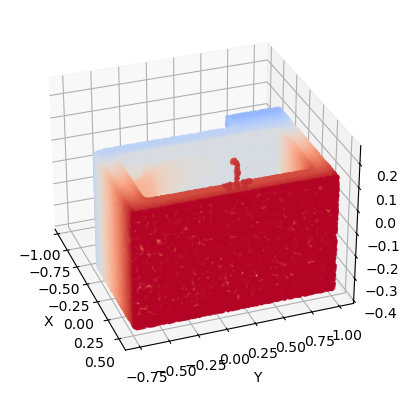

In [5]:
utils.draw_pointcloud(point_cloud)

Visualisation of neighbourhood function

In [72]:
point0 = point_cloud.pos[1]
nr_points = len(point_cloud.pos)
radius = .01
neighbours0 = utils.find_neighborhood(point_cloud.pos, point0, radius)

In [73]:
utils.draw_pointcloud_neighbour(point_cloud.pos, neighbours0, point0,radius,False)

In [74]:
neighbours0

tensor([[-0.6936,  0.5667, -0.0744],
        [-0.6936,  0.5744, -0.0731],
        [-0.6936,  0.5677, -0.0821],
        [-0.6936,  0.5698, -0.0774]])

In [75]:
def approximate_second_derivative_uniform(x, y):
    """
    2nd order central finite difference scheme assuming equally spaced points due to uniform sampling.
    :param x:
    :param y:
    :return:
    """
    n = len(x)

    if n < 3:
        raise ValueError("At least three points are required to approximate the second derivative.")

    # Assuming uniformly sampled x-axis
    h = x[1] - x[0]

    second_derivative = np.zeros(n)
    second_derivative[0] = (y[2] - 2 * y[1] + y[0]) / (h**2)  # Forward difference at first point

    for i in range(1, n - 1):
        second_derivative[i] = (y[i+1] - 2 * y[i] + y[i-1]) / (h**2)  # Central difference

    second_derivative[n-1] = (y[n-1] - 2 * y[n-2] + y[n-3]) / (h**2)  # Backward difference at last point

    return second_derivative

In [76]:
def approximate_second_derivative_2D(neighbors, point0):
    """
    2nd order central finite difference scheme for approximating the second derivative in 2D.
    :param neighbors: 2D NumPy array of neighboring points (x, y values)
    :param point0: 2D NumPy array of the central point (x, y values)
    :return: Approximated second derivative at point0
    """

    if neighbors.shape[0] < 3:
        raise ValueError("At least three neighboring points are required to approximate the second derivative.")

    # Assuming equally spaced points in the x-direction
    h = torch.mean(neighbors[1, :] - neighbors[0, :])

    second_derivative = (neighbors[2, 1] - 2 * point0[1] + neighbors[0, 1]) / (h**2)

    return second_derivative


In [77]:
neighboursxy = neighbours0[:,:2]
neighboursxy

tensor([[-0.6936,  0.5667],
        [-0.6936,  0.5744],
        [-0.6936,  0.5677],
        [-0.6936,  0.5698]])

In [78]:
approximate_second_derivative_2D(neighboursxy, point0[:2])

tensor(63.5344)

In [79]:
plt.scatter(neighboursxy[:,0],neighboursxy[:,1])
plt.scatter(point0[0],point0[1])

In [80]:
# average point left
left_avg = torch.mean(neighboursxy[neighboursxy[:,0]<point0[0]],axis=0)
right_avg = torch.mean(neighboursxy[neighboursxy[:,0]>point0[0]],axis=0)
left_avg

tensor([nan, nan])

In [81]:
plt.scatter(left_avg[0],left_avg[1])
plt.scatter(point0[0],point0[1])
plt.scatter(right_avg[0],right_avg[1])

In [82]:
def approximate_second_derivative_3points(left, central, right):
    """
    2nd order central finite difference scheme for approximating the second derivative.
    :param left: Value at the left point
    :param central: Value at the central point
    :param right: Value at the right point
    :return: Approximated second derivative at the central point
    """
    # average spacing h
    h = (right[0] - left[0]) / 2
    second_derivative = (right[1] - 2 * central[1] + left[1]) / (h**2)
    return second_derivative


In [83]:
right_avg

tensor([nan, nan])

In [84]:
approximate_second_derivative_3points(left_avg,point0[:2],right_avg)

tensor(nan)

In [85]:
# get neighbours
# for all  in xy, xz, yz:
    # find average right and left neighbour
    # compute 2nd order derivative
    #

In [86]:
def find_point_deriv(points_pos, radius=0.1):

    all_deriv = np.zeros(len(points_pos))
    for i, point in enumerate(points_pos):
        neighbours = utils.find_neighborhood(points_pos, point, radius)
        neighboursxy = neighbours[:,:2]
        left_avg = torch.mean(neighboursxy[neighboursxy[:,0]<point0[0]],axis=0)
        right_avg = torch.mean(neighboursxy[neighboursxy[:,0]>point0[0]],axis=0)
        all_deriv[i] = approximate_second_derivative_3points(left_avg,point0[:2],right_avg) # for now we only do xy-curvature
    return all_deriv


In [87]:
derivs = find_point_deriv(point_cloud.pos, radius)

In [ ]:
%matplotlib qt
utils.draw_pointcloud(point_cloud,coloring=derivs)

In [67]:
len(derivs)

100000